In [1]:
import arch
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
import statsmodels.api as sm
import warnings
import yfinance as yf
from datetime import date, datetime, timedelta
from operator import itemgetter
from sklearn.metrics import confusion_matrix
from typing import List, Tuple

from etl.load_volatility import get_data_with_vix
from indicators.transform import build_features
from indicators.temporal_features import difference_features


sns.set_style("darkgrid")

In [2]:
# EIA Weekly Report of oil storage inventory
storage_data_fp = "data/weekly_us_crude_stocks.xls"

storage_df = pd.read_excel(storage_data_fp, sheet_name="Data 1", skiprows=[0, 1])
storage_df.rename(columns={"Date": "date", storage_df.columns[1]: "oil_stock"}, inplace=True, errors="raise")

storage_df.set_index("date", inplace=True)
storage_df.index = pd.to_datetime(storage_df.index)
storage_df.tail()

,oil_stock
date,
2022-12-30,420646
2023-01-06,439607
2023-01-13,448015
2023-01-20,448548
2023-01-27,452688


In [3]:
ticker = "CL=F"
vix = "^OVX"
interval = "1d"
end_date = date.today()
start_date = datetime.strptime("2017-01-01", "%Y-%m-%d")

df = get_data_with_vix(ticker, vix=vix, start_date=start_date, end_date=end_date, interval=interval)

# Use flat stoarge across the week.
df = df.join(storage_df)
df["oil_stock"].fillna(method="ffill", inplace=True)

df["diff_oil_stock"] = df["oil_stock"].diff(periods=1)
df.dropna(inplace=True)

features, target = build_features(
    df,
    features_cols=["price", "volume", "vix", "diff_oil_stock"],
    add_lag_features={"price": [1, 2, 3, 7], "vix": [1, 2, 3, 7], "oil_stock": [7]},
    add_yearly_features=True
)

print(f"df: {df.shape}, features: {features.shape}, target: {target.shape}")


num_train_initial = 252*2
regularise = False
use_fixed_train_size = True

price_predictions = []
for test_index in range(num_train_initial, len(df)):
    train_index = test_index - num_train_initial if use_fixed_train_size else 0

    # Train - IS Data.
    X_train = features.iloc[train_index:test_index]
    y_train = target.iloc[train_index:test_index]

    # Linear Regression vs. ElasticNet (GLMNet).
    model = sm.OLS(endog=y_train, exog=X_train)
    model = model.fit_regularized() if regularise else model.fit()

    # Test - OOS Data: note double [[]] to preserve batch_dim==1.
    X_test = features.iloc[[test_index]]
    y_test = target.iloc[[test_index]]

    price_next_pred = model.predict(X_test)
    price_predictions.append(price_next_pred)

# Align predictions.
pred_series = pd.concat(price_predictions, axis=0)
pred_series.name = "price_pred"
pred_df = pred_series.to_frame()
df = df.join(pred_df)

df.tail()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
df: (1520, 18), features: (1520, 16), target: (1520,)


,price,volume,vix,oil_stock,diff_oil_stock,price_target,price-1,price-2,price-3,price-7,vix-1,vix-2,vix-3,vix-7,oil_stock-7,day_of_year,cos_day_of_year,sin_day_of_year,price_pred
Date,,,,,,,,,,,,,,,,,,,
2023-01-26,81.010002,291060,38.119999,448548.0,0.0,79.680000,80.150002,80.129997,81.620003,80.180000,38.540001,38.259998,37.299999,40.099998,448015.0,26,0.902030,0.431673,80.787339
2023-01-27,79.680000,367588,38.599998,452688.0,4140.0,77.900002,81.010002,80.150002,80.129997,79.480003,38.119999,38.540001,38.259998,39.250000,448015.0,27,0.894487,0.447094,79.114380
2023-01-30,77.900002,327426,40.180000,452688.0,0.0,78.870003,79.680000,81.010002,80.150002,80.330002,38.599998,38.119999,38.540001,39.020000,448015.0,30,0.870285,0.492548,78.014079
2023-01-31,78.870003,312734,38.549999,452688.0,0.0,76.410004,77.900002,79.680000,81.010002,81.309998,40.180000,38.599998,38.119999,37.810001,448548.0,31,0.861702,0.507415,78.996213
2023-02-01,76.410004,360859,37.990002,452688.0,0.0,75.879997,78.870003,77.900002,79.680000,81.620003,38.549999,40.180000,38.599998,37.299999,448548.0,32,0.852864,0.522133,76.364914


In [4]:
# TODO:
# [] Roll costs.
# [] Remove/smooth days of roll over.


# Did the model predict the direction correctly?
df["dir_pred"] = (df["price_pred"] > df["price"]).astype(int)
df["dir_target"] = (df["price_target"] > df["price"]).astype(int)

cm = confusion_matrix(y_true=df["dir_target"], y_pred=df["dir_pred"], labels=[0, 1])
print(f"Confusion Matrix: {cm}")
print(f"TP + TN: {cm[0, 0] + cm[1, 1]}\nFP + FN: {cm[0, 1] + cm[1, 0]}")
print(f"Accuracy: {(cm[0, 0] + cm[1, 1])/np.sum(cm)}")

Confusion Matrix: [[427 252]
 [531 310]]
TP + TN: 737
FP + FN: 783
Accuracy: 0.48486842105263156


In [5]:
print("Final Model")
model_df = pd.DataFrame.from_dict({"params": model.params, "pvalues": model.pvalues})
reject_h0 = model_df.query("pvalues <= 0.05")
fail_reject_h0 = model_df.query("pvalues > 0.05")
print(model_df)
print("-"*20)
print(f"Reject H0:\n {reject_h0}")
print("-"*20)
print(f"Fail to reject H0:\n {fail_reject_h0}")

Final Model
                       params       pvalues
const            1.524512e+01  8.920362e-04
price            9.802251e-01  1.215476e-71
volume           6.607438e-07  4.372488e-01
vix              5.745666e-02  9.406846e-02
diff_oil_stock  -8.627053e-05  4.051255e-02
price-1         -8.168679e-02  2.019368e-01
price-2         -3.692396e-04  9.954058e-01
price-3         -2.754236e-03  9.563580e-01
price-7          5.173135e-02  3.468554e-02
vix-1           -4.802436e-03  9.141180e-01
vix-2           -9.430595e-02  3.392534e-02
vix-3            5.221153e-02  1.536498e-01
vix-7            7.429369e-03  7.190051e-01
oil_stock-7     -2.713542e-05  9.450868e-04
cos_day_of_year -2.362866e-01  2.173771e-01
sin_day_of_year  6.187091e-01  1.683094e-03
--------------------
Reject H0:
                     params       pvalues
const            15.245120  8.920362e-04
price             0.980225  1.215476e-71
diff_oil_stock   -0.000086  4.051255e-02
price-7           0.051731  3.468554e-02
vi

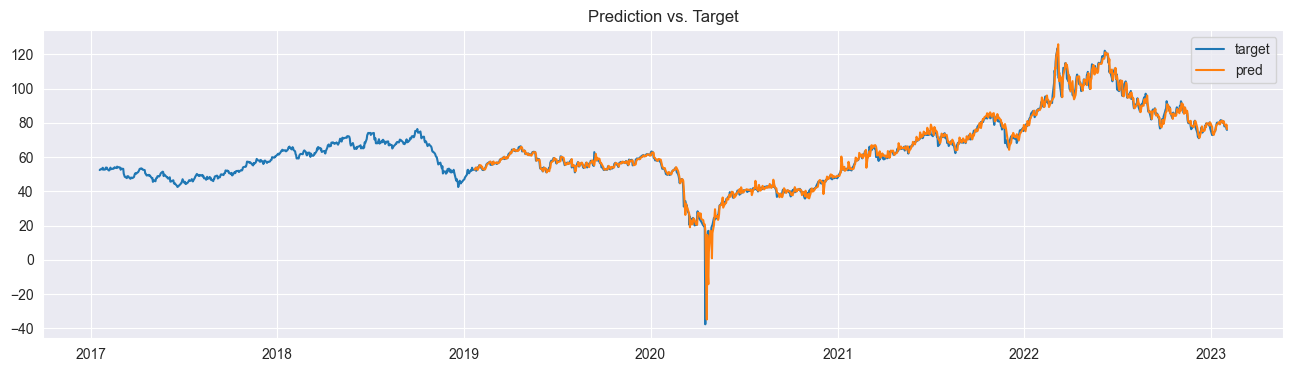

In [6]:
fig = plt.figure()
fig.set_size_inches(16, 4)

plt.plot(df["price_target"], label="target")
plt.plot(df["price_pred"], label="pred")
plt.title("Prediction vs. Target")
plt.legend()
plt.show()

In [18]:
indices = df["dir_pred"] == df["dir_target"]
preds_correct = df.loc[indices, "price_pred"]
preds_incorrect = df.loc[~indices, "price_pred"]

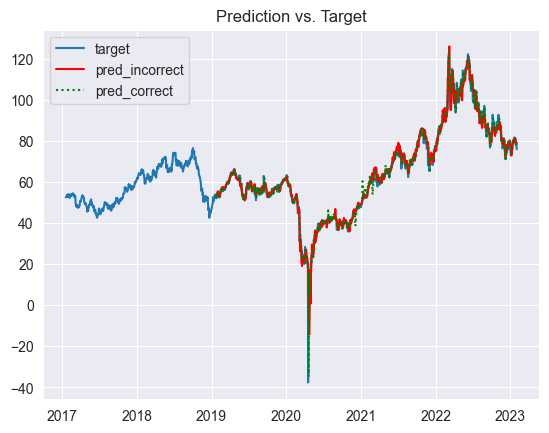

In [21]:
plt.plot(df["price_target"], label="target")
plt.plot(preds_incorrect, label="pred_incorrect", color="red")
plt.plot(preds_correct, label="pred_correct", linestyle="dotted", color="green")
plt.title("Prediction vs. Target")
plt.legend()
plt.show()

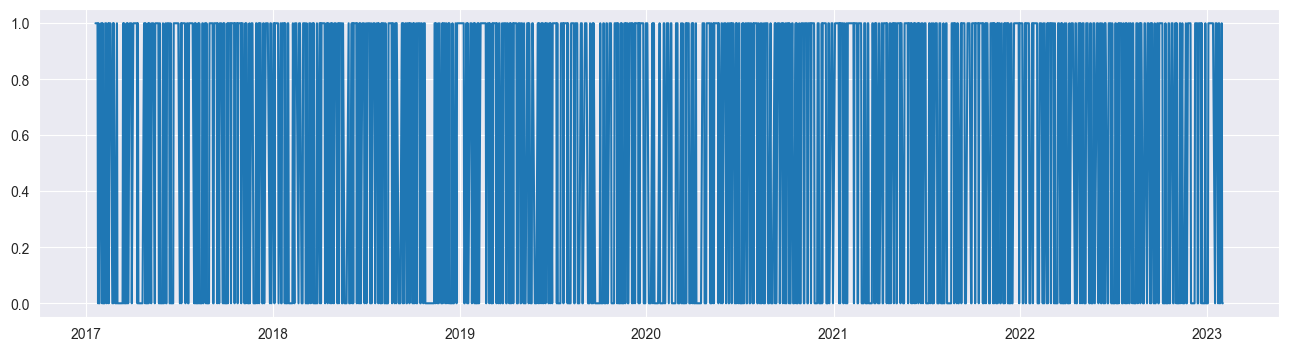

In [23]:
fig = plt.figure()
fig.set_size_inches(16, 4)

plt.plot(df["dir_target"], label="target")

In [24]:
df.dropna(inplace=True)
df["dir_target"].sum() / len(df)

0.5492125984251969